### Install scikit-video if not installed

In [1]:
pip install scikit-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 33.6 MB/s 


### Import Libraries

In [2]:
import skvideo.io
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from PIL import Image
import math
import time
import matplotlib.pyplot as plt

### Seperating Input and Output frames


Lets say we have n=4 frames 0 1 2 3 

first we seperate the color channels like 0r 0g 0b

then we stack these channels 

| x1 | x2 | y  |
|:---|:---|:---|
|  0r | 2r  | 1r  |
|  1r | 3r  | 2r  |
|  0g | 2g  | 1g  |
|  1g | 3g  | 2g  |
|  0b | 2b  | 1b  |
|  1b | 3b  | 2b  |


we make these 3 arrays

### Function

In [3]:
def videoToXYtensors(videoPath):
    
    # Opening the video
    video_data = None
    try:
      video_data = torch.tensor(skvideo.io.vread(videoPath), dtype=torch.float)
    except:
      print('Error opening video')
      return

    
    video_data = normalize(video_data)
    # Creating the 3 arrays x1,x2 and y
    X1 = video_data[:-2]
    X2 = video_data[2:]
    Y = video_data[1:-1]

    X1R = X1[:,:,:,0:1]
    X2R = X2[:,:,:,0:1]
    YR = Y[:,:,:,0:1]

    X1G = X1[:,:,:,1:2]
    X2G = X2[:,:,:,1:2]
    YG = Y[:,:,:,1:2]

    X1B = X1[:,:,:,2:3]
    X2B = X2[:,:,:,2:3]
    YB = Y[:,:,:,2:3]
    
    # stacking X1 and X2 for all 3 channels
    XR = torch.cat((X1R,X2R),axis = 3)
    XG = torch.cat((X1G,X2G),axis = 3)
    XB = torch.cat((X1B,X2B),axis = 3)
  

    # vertically stacking them
    X = torch.cat((XR.permute(0,3,1,2),XG.permute(0,3,1,2),XB.permute(0,3,1,2)),axis = 0)
    Y = torch.cat((YR.permute(0,3,1,2),YG.permute(0,3,1,2),YB.permute(0,3,1,2)),axis = 0)


    return X,Y
    

## Normalize and denormalize


In [4]:
def normalize(Y):
  return Y/255

def denormalize(Y):
  return Y*255

In [5]:
random_seed = 420
torch.manual_seed(random_seed)

## Creating the Dataset

In [6]:
class InterpolationDataset(Dataset):
  def __init__(self, input_frames, output_frames):
    self.X = input_frames
    self.Y = output_frames

  def __len__(self):
      return len(self.Y)
    
  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]
      



#### Creating Data loader

In [7]:
Xc ,Yc = videoToXYtensors("/content/InputVideo0.mp4")

dataset = InterpolationDataset(Xc,Yc)

In [8]:
batch_size = 16

train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

### The Model class

In [9]:
class VideoInterpolationModel(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
      
      nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1, padding_mode = 'replicate'),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1, padding_mode = 'replicate'),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1, padding_mode = 'replicate'),
            nn.ReLU(),

          nn.ConvTranspose2d(128,64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),

        nn.Upsample(scale_factor=2, mode='bilinear', ),
        nn.ConvTranspose2d(64,32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),

      nn.Upsample(scale_factor=2, mode='bilinear', ),
      nn.ConvTranspose2d(32,1, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
    )

  def forward(self, batch):
    return self.network(batch)

  def MSE_loss(self,Y,Y_prime):
   return torch.mean(((Y-Y_prime)**2))

  def accuracy(self,Y,Y_prime):
    return torch.sum(Y==Y_prime)/Y.numel

  def training_step(self, batch):
    inputs, outputs = batch 
    out = self(inputs)                # Generate predictions
    loss = self.MSE_loss(out, outputs) # Calculate loss
    return loss
    



### Setting up GPU

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

### The Train/Fit Function

In [12]:
losses = []

def fit(epochs, lr, model, train_loader, opt_func=torch.optim.Adam):
    global losses
    # start timer for whole training
    tick = time.time()
    history = []
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # start timer for epoch
        t1 = time.time()
        
        print(f'Epoch:{epoch}')

        model.train()
        # losses for each batch
        train_losses = []
        
        # Actual Training
        for batch in train_loader:
            loss = model.training_step(batch)
            
            print(f' l = {loss}')
            train_losses.append(loss)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        # stop timer for epoch
        t2 = time.time()
        print(f'time::{t2 - t1} sec,  or {(t2 - t1)/60 } minutes ')

        losses.append((sum(train_losses)/len(train_losses)))
        print(f"average loss = {losses[-1]}\n\n")
    # stop timer for whole training
    tock = time.time()
    print(f'time taken for {epochs} epochs:{tock - tick} sec,  or {(tock - tick)/60 } minutes ')
    return history




### Instantiating the model

In [13]:
model1 = VideoInterpolationModel()


train_dl = DeviceDataLoader(train_dl, device)
to_device(model1, device);

## Loading the parameters (Comment if training)

In [ ]:
model1.load_state_dict(torch.load('/content/model_params12'))
model1.eval()

VideoInterpolationModel(
  (network): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (7): ReLU()
    (8): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Upsample(scale_factor=2.0, mode=bilinear)
    (11): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Upsample(scale_factor=2.0, mode=bilinear)
    (14): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
  )
)

## Training the Model

In [35]:
fit(50,0.001,model1,train_dl)

## Saving the Parameters

### MUST DO AFTER TRAINING

In [ ]:
torch.save(model1.state_dict(), 'model_params_dust')

### Training loss graph

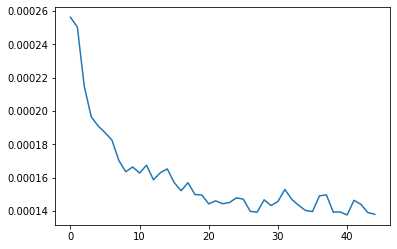

[0.000848211464472115, 0.00033666600938886404, 0.0002561765431892127, 0.0002502916904632002, 0.00021487101912498474, 0.0001965980773093179, 0.00019102399528492242, 0.0001869869593065232, 0.00018252023437526077, 0.00017029154696501791, 0.00016354456602130085, 0.0001663887669565156, 0.00016274394874926656, 0.00016747959307394922, 0.00015871522191446275, 0.00016295704699587077, 0.00016524246893823147, 0.0001570423337398097, 0.00015215460734907538, 0.0001569806772749871, 0.00014987093163654208, 0.000149585772305727, 0.00014426480629481375, 0.00014608720084652305, 0.00014435008051805198, 0.00014505768194794655, 0.0001479114143876359, 0.00014707482478115708, 0.00013976547052152455, 0.00013929372653365135, 0.00014668820949736983, 0.0001432653225492686, 0.00014568999176844954, 0.00015292575699277222, 0.00014698963786941022, 0.0001433399156667292, 0.00014030752936378121, 0.00013965234393253922, 0.0001490872964495793, 0.0001496685144957155, 0.0001393425918649882, 0.00013940644566901028, 0.000137

In [ ]:
l = []
for loss in losses:
  l.append(float(loss))

xpoints = np.array(range(len(l)-2))
ypoints = np.array(l[2:])

plt.plot(xpoints, ypoints)
plt.show()
print(l)

### Regenerating the Video

In [27]:
import gc # had to bring in garbage collector to free ram, else colab crashes

video_data = normalize(torch.tensor(skvideo.io.vread("/content/InputVideo0.mp4"), dtype=torch.float))


X1 = video_data[:-1]
X2 = video_data[1:]

del video_data
gc.collect()

X1R = X1[:,:,:,0:1]
X2R = X2[:,:,:,0:1]

X1G = X1[:,:,:,1:2]
X2G = X2[:,:,:,1:2]

X1B = X1[:,:,:,2:3]
X2B = X2[:,:,:,2:3]

del X2
gc.collect()

  # stacking X1 and X2
XR = torch.cat((X1R,X2R),axis = 3).permute(0,3,1,2)
XG = torch.cat((X1G,X2G),axis = 3).permute(0,3,1,2)
XB = torch.cat((X1B,X2B),axis = 3).permute(0,3,1,2)

  

### Generating The frames

In [28]:
Y = []
for i in range(int(len(XR)/16)):
  Yr = model1((XR[i*16:i*16+16]).cuda()).detach().cpu().permute(0,2,3,1).numpy() 
  Yg = model1((XG[i*16:i*16+16]).cuda()).detach().cpu().permute(0,2,3,1).numpy() 
  Yb = model1((XB[i*16:i*16+16]).cuda()).detach().cpu().permute(0,2,3,1).numpy()

  Yr = np.clip(Yr,0,1) 
  Yg = np.clip(Yg,0,1) 
  Yb = np.clip(Yb,0,1) 

  out = np.concatenate((Yr,Yg,Yb),axis=3)
  Y.append(out)
  

In [29]:
del X1R
del X2R

del X1G
del X2G

del X1B
del X2B


del XR
del XG
del XB

gc.collect()

94

In [30]:
F = np.concatenate(Y,axis=0)

F.shape

del Y
gc.collect()

53

In [31]:
video_data = normalize(np.array(skvideo.io.vread("/content/InputVideo0.mp4")))



X1 = video_data[:-1][:-2]

del video_data
gc.collect()

print(X1.shape)


(173, 512, 512, 3)


### Aligning the frames

In [32]:
video = []
for i in range(len(F)-1):
  filter = np.abs(X1[i+1]-X1[i])
  
  
  inverted_filter = 1 - filter
 
  newFrame = (X1[i]+X1[i+1]) * inverted_filter/2 + F[i] * filter
  video.append(X1[i])
  video.append(newFrame)



In [33]:
del F
del X1
gc.collect()


100

In [34]:
V = np.array(video)
del video
gc.collect()

V = denormalize(V)
print(V.shape)


(318, 512, 512, 3)


### Saving the output

In [35]:
skvideo.io.vwrite("outputvid4.mp4", V.astype('uint8'))
del V
gc.collect()

100